<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/%D0%94%D0%BC%D0%B8%D1%82%D1%80%D0%B8%D0%B9_%D0%A2%D0%B0%D1%80%D0%B0%D0%BD%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Железо: i7 k7700, rtx 2080ti

In [0]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, model_from_json  # Сеть прямого распространения
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalMaxPooling2D, \
    GlobalAveragePooling2D, AveragePooling2D, Flatten, ZeroPadding2D, Activation
from IPython.display import clear_output
from tensorflow.keras.applications.vgg16 import VGG16

from pathlib import Path
# Базовые слои для свёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, \
    GlobalAveragePooling2D
from tensorflow.keras import utils  # Используем дял to_categorical
from tensorflow.keras.preprocessing import image  # Для отрисовки изображений
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np  # Библиотека работы с массивами
import matplotlib.pyplot as plt  # Для отрисовки графиков
from PIL import Image  # Для отрисовки изображений
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop, Adamax, SGD, Nadam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import get_custom_objects

In [0]:
# Коллбек, отрисовывающий графики ошибки и точности
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.show()

In [0]:
TRAIN_PATH = 'F:/kaggle_1/middle_fmr'

BATCH_SIZE = 80 # 160
IMG_WIDTH = 192
IMG_HEIGHT = 108

IMG_WIDTH_SCALE = (int)(IMG_WIDTH / 2)
IMG_HEIGHT_SCALE = (int)(IMG_HEIGHT / 2)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=4,
    width_shift_range=0.04,
    height_shift_range=0.04,
    zoom_range=[0.8, 1.0],
    shear_range=0.04,
    brightness_range=[0.3, 1.0]
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH_SCALE, IMG_HEIGHT_SCALE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.1
)

# Проверочная выборка
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH_SCALE, IMG_HEIGHT_SCALE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 3427 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [0]:
model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_WIDTH_SCALE, IMG_HEIGHT_SCALE, 3)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4096, activation='relu'))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 54, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 54, 256)       590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 27, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 27, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 27, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 13, 256)       0         
____

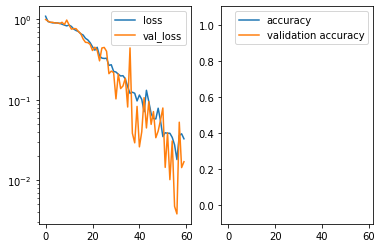

42/42 [==============================] - 20s 488ms/step - loss: 0.0327 - acc: 0.9892 - val_loss: 0.0170 - val_acc: 0.9906


In [0]:
plot_losses = PlotLosses()

print(train_generator.samples // BATCH_SIZE, validation_generator.samples // BATCH_SIZE)

EPOCHS = 60 # 200

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=1),
               
               ModelCheckpoint(filepath="best_model_8.hdf5", monitor='val_loss', verbose=1, save_best_only=True,
                               mode='auto'),
               plot_losses],
    epochs=EPOCHS,
    verbose=1
)

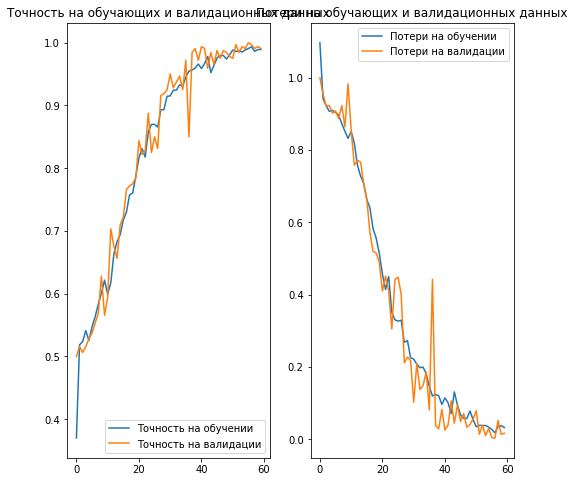

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность на обучении')
plt.plot(epochs_range, val_acc, label='Точность на валидации')
plt.legend(loc='lower right')
plt.title('Точность на обучающих и валидационных данных')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Потери на обучении')
plt.plot(epochs_range, val_loss, label='Потери на валидации')
plt.legend(loc='upper right')
plt.title('Потери на обучающих и валидационных данных')

plt.show()

#model.save('best_model_8_last.hdf5')